# Spam Detection Pipeline

Complete implementation with:
1. Data Preprocessing
2. Feature Extraction (Binary, Count, TF-IDF, Word2Vec)
3. Model Training & Evaluation (Naive Bayes, SVM, Random Forest)

## 1. Import Libraries

In [1]:
# pip install gensim

In [2]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from gensim.models import Word2Vec

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Load Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Sroor For Laptop\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1


In [4]:
df = pd.read_csv(f"{path}/spam.csv", encoding='latin-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# Rename columns
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)

# Keep only relevant columns
df = df[['label', 'text']]

print(f"Dataset shape: {df.shape}")

Dataset shape: (5572, 2)


In [7]:
print(f"\nClass distribution:\n{df['label'].value_counts()}")


Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


In [8]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
print("Number of missing values in each column:")
print(df.isnull().sum())

Number of missing values in each column:
label    0
text     0
dtype: int64


## 3. Data Preprocessing

In [11]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Clean and preprocess text"""
    # Lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing text...")
df['cleaned_text'] = df['text'].apply(clean_text)
df['clean_tokens'] = df['cleaned_text'].apply(word_tokenize)

print("Preprocessing complete!")
df[['text', 'cleaned_text']].head()

Preprocessing text...
Preprocessing complete!


,text,cleaned_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


## 4. Feature Extraction

### a) Binary Encoding (Sentence-level)

In [12]:
print("Extracting Binary Encoding features...")
binary_vectorizer = CountVectorizer(binary=True)
X_binary = binary_vectorizer.fit_transform(df['cleaned_text'])
print(f"Binary Encoding Shape: {X_binary.shape}")

Extracting Binary Encoding features...
Binary Encoding Shape: (5572, 7529)


### b) Count Vectorization (Sentence-level)

In [13]:
print("Extracting Count Vectorization features...")
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(df['cleaned_text'])
print(f"Count Vectorization Shape: {X_count.shape}")

Extracting Count Vectorization features...
Count Vectorization Shape: (5572, 7529)


### c) TF-IDF (Sentence-level)

In [14]:
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(f"TF-IDF Shape: {X_tfidf.shape}")

Extracting TF-IDF features...
TF-IDF Shape: (5572, 7529)


### d) Word2Vec (Word-level)

In [15]:
print("Training Word2Vec model on words...")

# Prepare tokenized sentences
tokenized_sentences = df['clean_tokens'].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to average word vectors for a document
def document_vector(doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    if not doc:
        return np.zeros(100)
    return np.mean(w2v_model.wv[doc], axis=0)

X_word2vec = np.array([document_vector(doc) for doc in tokenized_sentences])
print(f"Word2Vec Shape: {X_word2vec.shape}")

Training Word2Vec model on words...
Word2Vec Shape: (5572, 100)


## 5. Prepare Labels

In [16]:
# Convert labels to numeric
y = df['label'].map({'ham': 0, 'spam': 1})
print(f"Labels shape: {y.shape}")
print(f"Label distribution:\n{y.value_counts()}")

Labels shape: (5572,)
Label distribution:
label
0    4825
1     747
Name: count, dtype: int64


## 6. Model Training & Evaluation

### Helper Functions

In [19]:
from imblearn.under_sampling import RandomUnderSampler

In [20]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a single model"""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Print results
    print(f"\n--- {model_name} ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    return {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def evaluate_feature_set(X, y, feature_name, use_naive_bayes=True):
    """Evaluate all models on a feature set"""
    print(f"\n{'='*70}")
    print(f"Evaluating Models on {feature_name} Features")
    print(f"{'='*70}")
    
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    results = {}

    # Naive Bayes (only for non-negative features)
    if use_naive_bayes:
        nb_model = MultinomialNB()
        results['Naive Bayes'] = train_evaluate_model(nb_model, X_train, X_test, y_train, y_test, 'Naive Bayes')
    
    # SVM
    svm_model = SVC(kernel='linear', probability=True, class_weight='balanced')
    results['SVM'] = train_evaluate_model(svm_model, X_train, X_test, y_train, y_test, 'SVM')
    
    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    results['Random Forest'] = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')
    
    return results, X_test, y_test

### Evaluate Binary Encoding

In [21]:
binary_results, X_test_binary, y_test_binary = evaluate_feature_set(X_binary, y, "Binary Encoding")


Evaluating Models on Binary Encoding Features

--- Naive Bayes ---
Accuracy:  0.9283
Precision: 0.6620
Recall:    0.9463
F1 Score:  0.7790

--- SVM ---
Accuracy:  0.9668
Precision: 0.8544
Recall:    0.9060
F1 Score:  0.8795

--- Random Forest ---
Accuracy:  0.9659
Precision: 0.8364
Recall:    0.9262
F1 Score:  0.8790


### Evaluate Count Vectorization

In [22]:
count_results, X_test_count, y_test_count = evaluate_feature_set(X_count, y, "Count Vectorization")


Evaluating Models on Count Vectorization Features

--- Naive Bayes ---
Accuracy:  0.9274
Precision: 0.6589
Recall:    0.9463
F1 Score:  0.7769

--- SVM ---
Accuracy:  0.9641
Precision: 0.8428
Recall:    0.8993
F1 Score:  0.8701

--- Random Forest ---
Accuracy:  0.9632
Precision: 0.8253
Recall:    0.9195
F1 Score:  0.8698


### Evaluate TF-IDF

In [23]:
tfidf_results, X_test_tfidf, y_test_tfidf = evaluate_feature_set(X_tfidf, y, "TF-IDF")


Evaluating Models on TF-IDF Features

--- Naive Bayes ---
Accuracy:  0.9139
Precision: 0.6137
Recall:    0.9597
F1 Score:  0.7487

--- SVM ---
Accuracy:  0.9695
Precision: 0.8808
Recall:    0.8926
F1 Score:  0.8867

--- Random Forest ---
Accuracy:  0.9614
Precision: 0.8118
Recall:    0.9262
F1 Score:  0.8652


### Evaluate Word2Vec (Word-level)

In [24]:
# Word2Vec has negative values, so Naive Bayes won't work
w2v_results, X_test_w2v, y_test_w2v = evaluate_feature_set(X_word2vec, y, "Word2Vec (Word-level)", use_naive_bayes=False)


Evaluating Models on Word2Vec (Word-level) Features

--- SVM ---
Accuracy:  0.7130
Precision: 0.2708
Recall:    0.6779
F1 Score:  0.3870

--- Random Forest ---
Accuracy:  0.9363
Precision: 0.7241
Recall:    0.8456
F1 Score:  0.7802


## 7. Find Best Model

In [25]:
# Collect all results
all_results = {
    'Binary Encoding': binary_results,
    'Count Vectorization': count_results,
    'TF-IDF': tfidf_results,
    'Word2Vec': w2v_results
}

# Find best model
best_f1 = 0
best_model_info = None

for feature_name, models in all_results.items():
    for model_name, result in models.items():
        f1 = result['f1_score']
        if f1 > best_f1:
            best_f1 = f1
            best_model_info = (feature_name, model_name, result)

if best_model_info:
    feature_name, model_name, result = best_model_info
    print(f"\n{'='*70}")
    print(f"BEST MODEL: {model_name} with {feature_name} features")
    print(f"F1 Score: {best_f1:.4f}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"{'='*70}")


BEST MODEL: SVM with TF-IDF features
F1 Score: 0.8867
Accuracy: 0.9695
Precision: 0.8808
Recall: 0.8926


## 8. Save Best Model

In [26]:
# Create models directory
if not os.path.exists('models'):
    os.makedirs('models')

# Save best model
if best_model_info:
    feature_name, model_name, result = best_model_info
    model_path = os.path.join('models', 'best_spam_model.pkl')
    joblib.dump(result['model'], model_path)
    print(f"\nBest model saved to {model_path}")
    
    # Save appropriate vectorizer
    if 'Binary' in feature_name:
        vectorizer_path = os.path.join('models', 'binary_vectorizer.pkl')
        joblib.dump(binary_vectorizer, vectorizer_path)
    elif 'Count' in feature_name:
        vectorizer_path = os.path.join('models', 'count_vectorizer.pkl')
        joblib.dump(count_vectorizer, vectorizer_path)
    elif 'TF-IDF' in feature_name:
        vectorizer_path = os.path.join('models', 'tfidf_vectorizer.pkl')
        joblib.dump(tfidf_vectorizer, vectorizer_path)
    
    print(f"Vectorizer saved to {vectorizer_path}")


Best model saved to models\best_spam_model.pkl
Vectorizer saved to models\tfidf_vectorizer.pkl


## 9. Visualize Confusion Matrix for Best Model

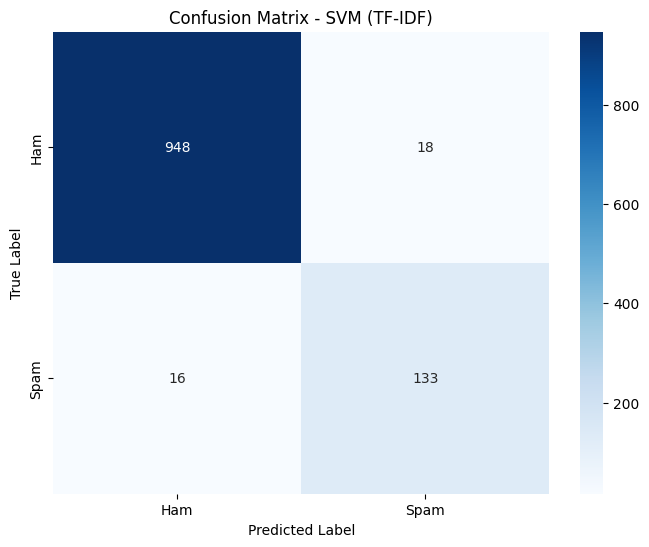


Confusion Matrix:
[[948  18]
 [ 16 133]]


In [27]:
if best_model_info:
    feature_name, model_name, result = best_model_info
    
    # Get appropriate test data
    if 'Binary' in feature_name:
        y_test_best = y_test_binary
    elif 'Count' in feature_name:
        y_test_best = y_test_count
    elif 'TF-IDF' in feature_name:
        y_test_best = y_test_tfidf
    else:
        y_test_best = y_test_w2v
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_best, result['predictions'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix - {model_name} ({feature_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"\nConfusion Matrix:\n{cm}")